In [6]:
# draft of SVM.py. Doesn't represent the final look of SVM.py.
import math
import numpy as np
import matplotlib.pyplot as plt

def clip(alpha, L, H):
    ''' 
        clip alpha to lie within range [L, H].
    '''
    if alpha < L:
        return L
    elif alpha > H:
        return H
    else:
        return alpha
    
def select_j(i, m):
    """
        Select a number in np.arange(m) that doesn't equal to i.
    """
    j = np.random.choice(m-1, 1)
    if j == i:
        j = j + 1
    return j

def get_w(alphas, dataset, target):
    """
        alphas is a column vector. w is a column vector. dataset is not extended by ones.
        f = x*w + b where x is a row of the dataset.
    """
    w = (dataset.T)@(alphas*target)
    return w

def f(w, b, x):
    return x@w + b

def predict(w, b, X):
    """
        X is data.
    """
    m = X.shape[0]
    labels = np.zeros((m,1))
    for i in np.arange(m):
        if f(w, b, X[i,:])>= 0:
            labels[i, 0] = 1
        else:
            labels[i, 0] = -1
    return labels

def rbf(u, v, gamma):
    """
        rbf kernel. u and v are row vectors.
    """
    return math.exp(-gamma * (u-v)@((u-v).T))

def poly(u, v, d):
    """
        polynomial kernel (1 + u \cdot v)^d where d is degree. u and v are row vectors.
    """
    return (1+u@(v.T))**d

def accuracy(trueLabels, predLabels):
    return float(sum(trueLabels == predLabels))/ float(len(trueLabels))

In [5]:
def simple_smo(X, y, C, tol, iterations):
    """
        C: regularization parameter. See PRML (7.33) p333.
        tol: numerical tolerance
        X: dataset without extended column of ones 
        y: target or label.
        This function computes alphas (Lagrange mulipliers) and 
        return the corresponding w, b.
    """
    (m, n) = X.shape
    alphas = np.zeros((m, 1))
    b = 0
    passes = 0
    while (passes < iterations):
        num_changed_alphas = 0
        for i in np.arange(m):
            Ei = f(get_w(alphas, X, y), b, X[i, :]) - y[i]
            if ((y[i, 0]*Ei < -tol) and (alphas[i, 0] < C)) or ((y[i, 0]*Ei > tol) and (alphas[i, 0] > 0)):
                j = select_j(i, m)
                Ej = f(get_w(alphas, X, y), b, X[j, :]) - y[j]
                alphaIold = np.copy(alphas[i]); # prevent alphaIold being modified unexpectedly
                alphaJold = np.copy(alphas[j]);
                if (y[i] != y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H:
                    continue # continue to next i
                eta = 2.0 * X[i,:]@(X[j,:].T) - X[i,:]@(X[i,:].T) - X[j,:]@(X[j,:].T)
                if eta >= 0:
                    continue
                # Compute and clip new value for alphas[j]
                alphas[j] = alphas[j] - y[j]*(Ei - Ej)/eta  
                alphas[j] = clip(alphas[j], L, H)
                if abs(alphaJold - alphas[j]) < 0.00001:
                    continue 
                alphas[i] = alphas[i] + y[i]*y[j]*(alphaJold - alphas[j])
                # compute b1 and b2
                b1 = b - Ei- y[i]*(alphas[i]-alphaIold)*X[i,:]@(X[i,:].T) - \
                y[j]*(alphas[j]-alphaJold)*X[i,:]@(X[j,:].T)
                b2 = b - Ej- y[i]*(alphas[i]-alphaIold)*X[i,:]@(X[j,:].T) - \
                y[j]*(alphas[j]-alphaJold)*X[j,:]@(X[j,:].T)
                # compute b
                if (0 < alphas[i]) and (alphas[i] < C):
                    b = b1
                elif (0 < alphas[j]) and (alphas[j] < C):
                    b = b2
                else:
                    b = (b1 + b2)/2.0  
                num_changed_alphas += 1
            if (num_changed_alphas == 0): 
                passes += 1
            else: 
                passes = 0
    return [get_w(alphas, X, y), b]

In [3]:
A = np.array([[-3, -2, -1],
[-2, 3, -1],
[-1, -4, -1],
[2, 3, -1],
[3, 4, -1],
[-1, 9, 1],
[2, 14, 1],
[1, 17, 1],
[3, 12, 1],
[0, 8, 1]])

[[-0.08692265]
 [ 0.43461325]] and [[-2.47768506]]


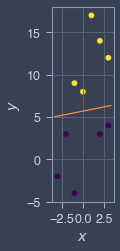

In [4]:
X = A[:, :2]
y = A[:, 2].reshape((10,1))
C = 0.6
tol = 0.001
iterations = 400
[w, b] = simple_smo(X, y, C, tol, iterations)

print("{} and {}".format(w,b))
plt.figure()
plt.scatter(X[:,0], X[:,1], c = 3*y)
#plt.xlim(-1,15)
plt.gca().set_aspect("equal")
plt.xlabel("$x$")
plt.ylabel("$y$")
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = -w[0,0]/w[1,0]*x_vals - b[0,0]/w[1,0]
plt.plot(x_vals, y_vals, c="y");

In [6]:
print(predict(w, b, X))

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


In [8]:
accuracy(predict(w, b, X), y)

1.0

[-1 -1  1  1  1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1
  1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1 -1  1
 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1  1
  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1
  1 -1  1 -1]


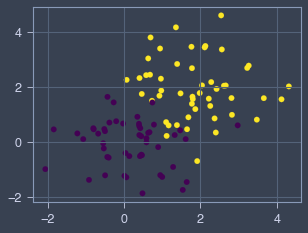

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers = [[0,0], [2,2]])
for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1
    else:
        continue
print(y)
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y)

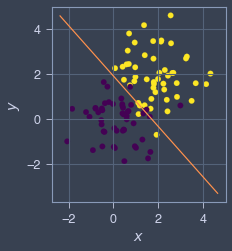

In [12]:
C = 0.6
tol = 0.001
iterations = 400
y = y.reshape((len(y),1))
[w, b] = simple_smo(X, y, C, tol, iterations)
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y)
#plt.xlim(-1,15)
plt.gca().set_aspect("equal")
plt.xlabel("$x$")
plt.ylabel("$y$")
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = -w[0,0]/w[1,0]*x_vals - b[0,0]/w[1,0]
plt.plot(x_vals, y_vals, c="y");

In [7]:
gamma = -1
u = np.array([0,1])
v = np.array([0,0])
rbf(u,v,gamma)

2.718281828459045

In [9]:
d = 2
poly(u, u, d)


4